In [13]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from scipy.optimize import minimize
from scipy.stats import norm
import numpy_financial as npf
import requests

In [14]:
def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex3/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df


In [36]:
eth_df = generate_df("ethereum_2020-12-1_2022-6-14.csv")
sol_df = generate_df("solana_2020-12-1_2022-6-14.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-6-14.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-6-14.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-6-14.csv")
btc_df = generate_df("bitcoin_2020-12-1_2022-6-14.csv")

In [16]:
#dynamic data sets
start_time = datetime(2020,12,1)
principal_usd = 100000.00
portfolio_coins = ['ETH','SOL','AVAX','NEAR','FTM']

In [17]:
psg_staking_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'], avax_df['Close'], near_df['Close'],ftm_df['Close']],axis=1)
psg_staking_portfolio_df.columns = portfolio_coins
psg_staking_portfolio_df['PORTFOLIO_NET'] = principal_usd
psg_staking_portfolio_df['PORTFOLIO_STAKING_NET'] = principal_usd
psg_staking_portfolio_df


,ETH,SOL,AVAX,NEAR,FTM,PORTFOLIO_NET,PORTFOLIO_STAKING_NET
Date,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,100000.0,100000.0
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,100000.0,100000.0
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,100000.0,100000.0
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,100000.0,100000.0
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,100000.0,100000.0
...,...,...,...,...,...,...,...
2022-06-09,1800.684784,39.930077,24.386851,5.074759,0.335923,100000.0,100000.0
2022-06-10,1676.316831,37.083127,22.070711,4.493525,0.306474,100000.0,100000.0
2022-06-11,1539.500300,33.963300,19.860800,4.083260,0.276528,100000.0,100000.0


In [18]:
# Construct portfolio:

def model(interval_data_set, portfolio_df):

    monthly_data_df_set = []

    def calculate_allocation(coin,allocation,input_df,portfolio_net):
        input_df[f'{coin}_ALLOC'] = allocation
        input_df[f'{coin}_NET_ALLOC_USD'] = (input_df[f'{coin}_ALLOC'] * portfolio_net)  
        input_df[f'{coin}_INIT_AMNT'] = round(input_df[f'{coin}_NET_ALLOC_USD'] / float(input_df[f'{coin}'].iloc[0]),2)
        input_df[f'{coin}_AMNT'] = input_df[f'{coin}_INIT_AMNT']
        input_df[f'{coin}_NET'] = round(input_df[f'{coin}_INIT_AMNT'] * input_df[f'{coin}'],2)
        
    def calculate_allocation_yield(coin,allocation,input_df,portfolio_staking_net):
        input_df[f'{coin}_ALLOC_YIELD'] = allocation
        input_df[f'{coin}_NET_ALLOC_USD_YIELD'] = (input_df[f'{coin}_ALLOC'] * portfolio_staking_net)  
        input_df[f'{coin}_INIT_AMNT_YIELD'] = round(input_df[f'{coin}_NET_ALLOC_USD_YIELD'] / float(input_df[f'{coin}'].iloc[0]),2)
       
    # todo refactor
    def re_calculate_portfolio_net(input_df): 
        input_df['PORTFOLIO_NET'] = input_df['ETH_NET'] + input_df['SOL_NET'] + input_df['AVAX_NET'] + input_df['NEAR_NET']+ input_df['FTM_NET']

    def calculate_yield(annual_yield,input_df,coin):
        ANNUAL_YIELD_PERCENTAGE = annual_yield / 100
        DAILY_YIELD_PERCENTAGE = (1 + ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
        input_df[f'{coin}_Daily_Rate'] = DAILY_YIELD_PERCENTAGE
        input_df[f'{coin}_AMNT_YIELD'] = input_df[f'{coin}_INIT_AMNT_YIELD'] * (1 + DAILY_YIELD_PERCENTAGE) ** (input_df['Day_Count_Cum'])
        input_df[f'{coin}_NET_YIELD'] = round(input_df[f'{coin}_AMNT_YIELD'] * input_df[f"{coin}"],2)

    def re_calculate_portfolio_staking_net(input_df):
        input_df['PORTFOLIO_STAKING_NET'] = input_df['ETH_NET_YIELD'] + input_df['SOL_NET_YIELD'] + input_df['AVAX_NET_YIELD'] + input_df['NEAR_NET_YIELD']+ input_df['FTM_NET_YIELD']

    prior_month_df = None
    
    for state in interval_data_set:
        monthly_portfolio_df = portfolio_df[(portfolio_df.index < state["end"]) & (psg_staking_portfolio_df.index >= state["start"])].copy()
        if prior_month_df is None:
            seed_df = portfolio_df.loc[(portfolio_df.index == state["start"])].copy()
        else:
            seed_df = prior_month_df.iloc[-1:]
            #print(seed_df["PORTFOLIO_NET"],seed_df["PORTFOLIO_STAKING_NET"])

        monthly_portfolio_df['Day_Count'] = 1
        monthly_portfolio_df['Day_Count_Cum'] = monthly_portfolio_df['Day_Count'].cumsum()

        monthly_portfolio_net = round(seed_df['PORTFOLIO_NET'].iloc[0],2)
        monthly_portfolio_staking_net = round(seed_df['PORTFOLIO_STAKING_NET'].iloc[0],2)
        #print(monthly_portfolio_net,monthly_portfolio_staking_net)

        for i in range(len(portfolio_coins)):
            coin = portfolio_coins[i]
            allocation = state["allocations"][i]
            yield_value = state["yields"][i]
            calculate_allocation(coin,allocation,monthly_portfolio_df,monthly_portfolio_net)
            calculate_allocation_yield(coin,allocation,monthly_portfolio_df,monthly_portfolio_staking_net)
            calculate_yield(yield_value,monthly_portfolio_df,coin)
        re_calculate_portfolio_net(monthly_portfolio_df)
        re_calculate_portfolio_staking_net(monthly_portfolio_df)
        monthly_data_df_set.append(monthly_portfolio_df)
        prior_month_df = monthly_portfolio_df

       
    result_basket_df = pd.concat(monthly_data_df_set,axis=0)
    return result_basket_df


In [19]:
def plot(input_df,monthly_data_set):
    plt.figure(figsize=(16, 8), dpi=150)
    ax = plt.axes()

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_facecolor("black");

    plot_df = pd.DataFrame(columns =['Date','Basket No Yield','PSG Staking Fund','BTC Performance','ETH Performance','AVAX Performance'])


    input_df['PSG Staking Fund'] = input_df['PORTFOLIO_STAKING_NET']
    input_df['Basket No Yield'] = input_df['PORTFOLIO_NET']
    input_df['ETH Performance'] = input_df['ETH_NET']
    input_df['SOL Performance'] = input_df['SOL_NET']
    input_df['AVAX Performance'] = input_df['AVAX_NET']
    input_df['NEAR Performance'] = input_df['NEAR_NET']
    input_df['FTM Performance'] = input_df['FTM_NET']

    plot_df.set_index('Date',inplace=True)
    # using plot method to plot open prices.
    # in plot method we set the label and color of the curve.
    input_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
    input_df['Basket No Yield'].plot(label='Basket No Yield', color='red')
    input_df['ETH Performance'].plot(label='ETH', color='blue')
    input_df['SOL Performance'].plot(label='SOL', color='orange')
    input_df['AVAX Performance'].plot(label='AVAX', color='purple')
    input_df['NEAR Performance'].plot(label='NEAR', color='violet')
    input_df['FTM Performance'].plot(label='FTM', color='yellow')
    #compare_df['21Shares HODL ETP'].plot(label='21Shares HODL ETP', color='red')
    #compare_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')

    # adding title to the plot
    plt.title('2 Year Comparison Over 21 Shares ETP Performance',color="white")

    # adding Label to the x-axis
    plt.xlabel('Time Over 2 Years',color='black')
    plt.ylabel('Amount in $',color='black')

    current_values = ax.get_yticks()
    # # using format string '{:.0f}' here but you can choose others
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

    #plot vertical line
    for state in monthly_data_set:    
        plt.axvline(x=state["end"], color='red', linestyle='--')
    # adding legend to the curve
    plt.legend();

In [33]:
def plot_presentation(input_df,monthly_data_set):
    plt.figure(figsize=(16, 8), dpi=150)
    ax = plt.axes()

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_facecolor("black");

    plot_df = pd.DataFrame(columns =['Date','Basket No Yield','PSG Staking Fund','BTC Performance','ETH Performance','AVAX Performance'])


    input_df['PSG Staking Fund'] = input_df['PORTFOLIO_STAKING_NET']
    input_df['Basket No Yield'] = input_df['PORTFOLIO_NET']
    input_df['ETH Performance'] = input_df['ETH_NET']
    input_df['SOL Performance'] = input_df['SOL_NET']
    input_df['AVAX Performance'] = input_df['AVAX_NET']
    input_df['NEAR Performance'] = input_df['NEAR_NET']
    input_df['FTM Performance'] = input_df['FTM_NET']
    

    plot_df.set_index('Date',inplace=True)
    # using plot method to plot open prices.
    # in plot method we set the label and color of the curve.
    input_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
    input_df['Basket No Yield'].plot(label='Basket No Yield', color='red')
    input_df['ETH Performance'].plot(label='ETH', color='blue')
    input_df['SOL Performance'].plot(label='SOL', color='orange')
    input_df['AVAX Performance'].plot(label='AVAX', color='purple')
    input_df['NEAR Performance'].plot(label='NEAR', color='violet')
    input_df['FTM Performance'].plot(label='FTM', color='yellow')
    #compare_df['21Shares HODL ETP'].plot(label='21Shares HODL ETP', color='red')
    #compare_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')

    # adding title to the plot
    plt.title('2 Year Comparison Over 21 Shares ETP Performance',color="white")

    # adding Label to the x-axis
    plt.xlabel('Time Over 2 Years',color='white')
    plt.ylabel('Amount in $',color='white')

    current_values = ax.get_yticks()
    # # using format string '{:.0f}' here but you can choose others
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

    #plot vertical line
    for state in monthly_data_set:    
        plt.axvline(x=state["end"], color='red', linestyle='--')
    # adding legend to the curve
    plt.legend();

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


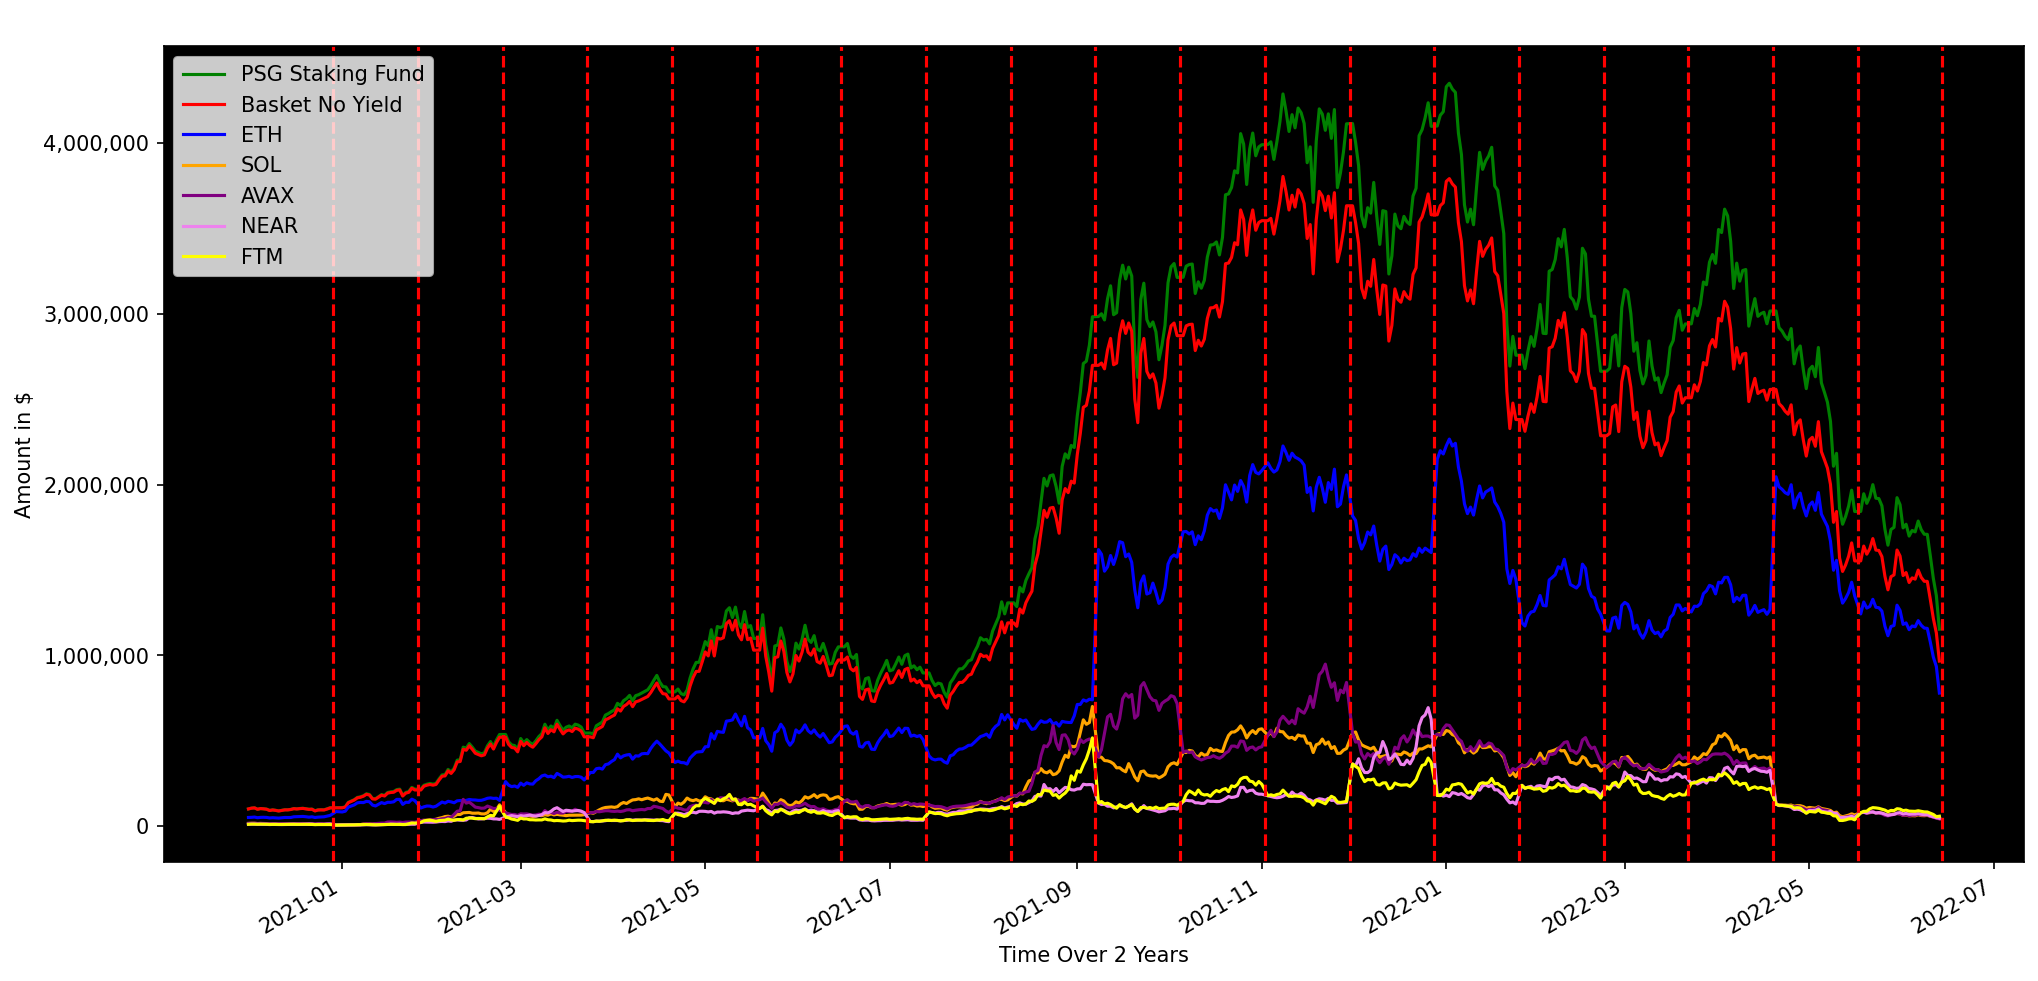

In [37]:
monthly_data_set_1 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[18.00,15.75,19.39,10.00,14.19]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": [0.80,0.05,0.05,0.05,0.05],
        "yields":[18.00,15.75,19.39,10.00,14.19]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[18.00,15.75,19.39,10.00,14.19]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations":  [0.60,0.15,0.15,0.05,0.05],
        "yields":[18.00,15.75,19.39,10.00,14.19]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[18.00,15.75,19.39,10.00,14.19]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[18.00,15.75,19.39,10.00,14.19]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":   [0.60,0.15,0.15,0.05,0.05],
        "yields":[18.00,15.75,19.39,10.00,14.19] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":  [0.60,0.15,0.15,0.05,0.05],
        "yields":[18.00,15.75,19.39,10.00,14.19]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":   [0.60,0.15,0.15,0.05,0.05],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
    {
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":  [0.60,0.15,0.15,0.05,0.05],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[18.00,15.75,19.39,10.00,14.19]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":  [0.60,0.15,0.15,0.05,0.05],
        "yields":[18.00,15.75,19.39,10.00,14.19]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations": [0.50,0.15,0.15,0.10,0.10],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":  [0.80,0.05,0.05,0.05,0.05],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    },
    {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations":  [0.80,0.05,0.05,0.05,0.05],
        "yields":[8.00,5.75,9.39,10.00,14.19]        
    }
]


#monthly_data_set
plot(model(monthly_data_set_1,psg_staking_portfolio_df),monthly_data_set_1)
#plot_presentation(model(monthly_data_set_1,psg_staking_portfolio_df),monthly_data_set_1)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


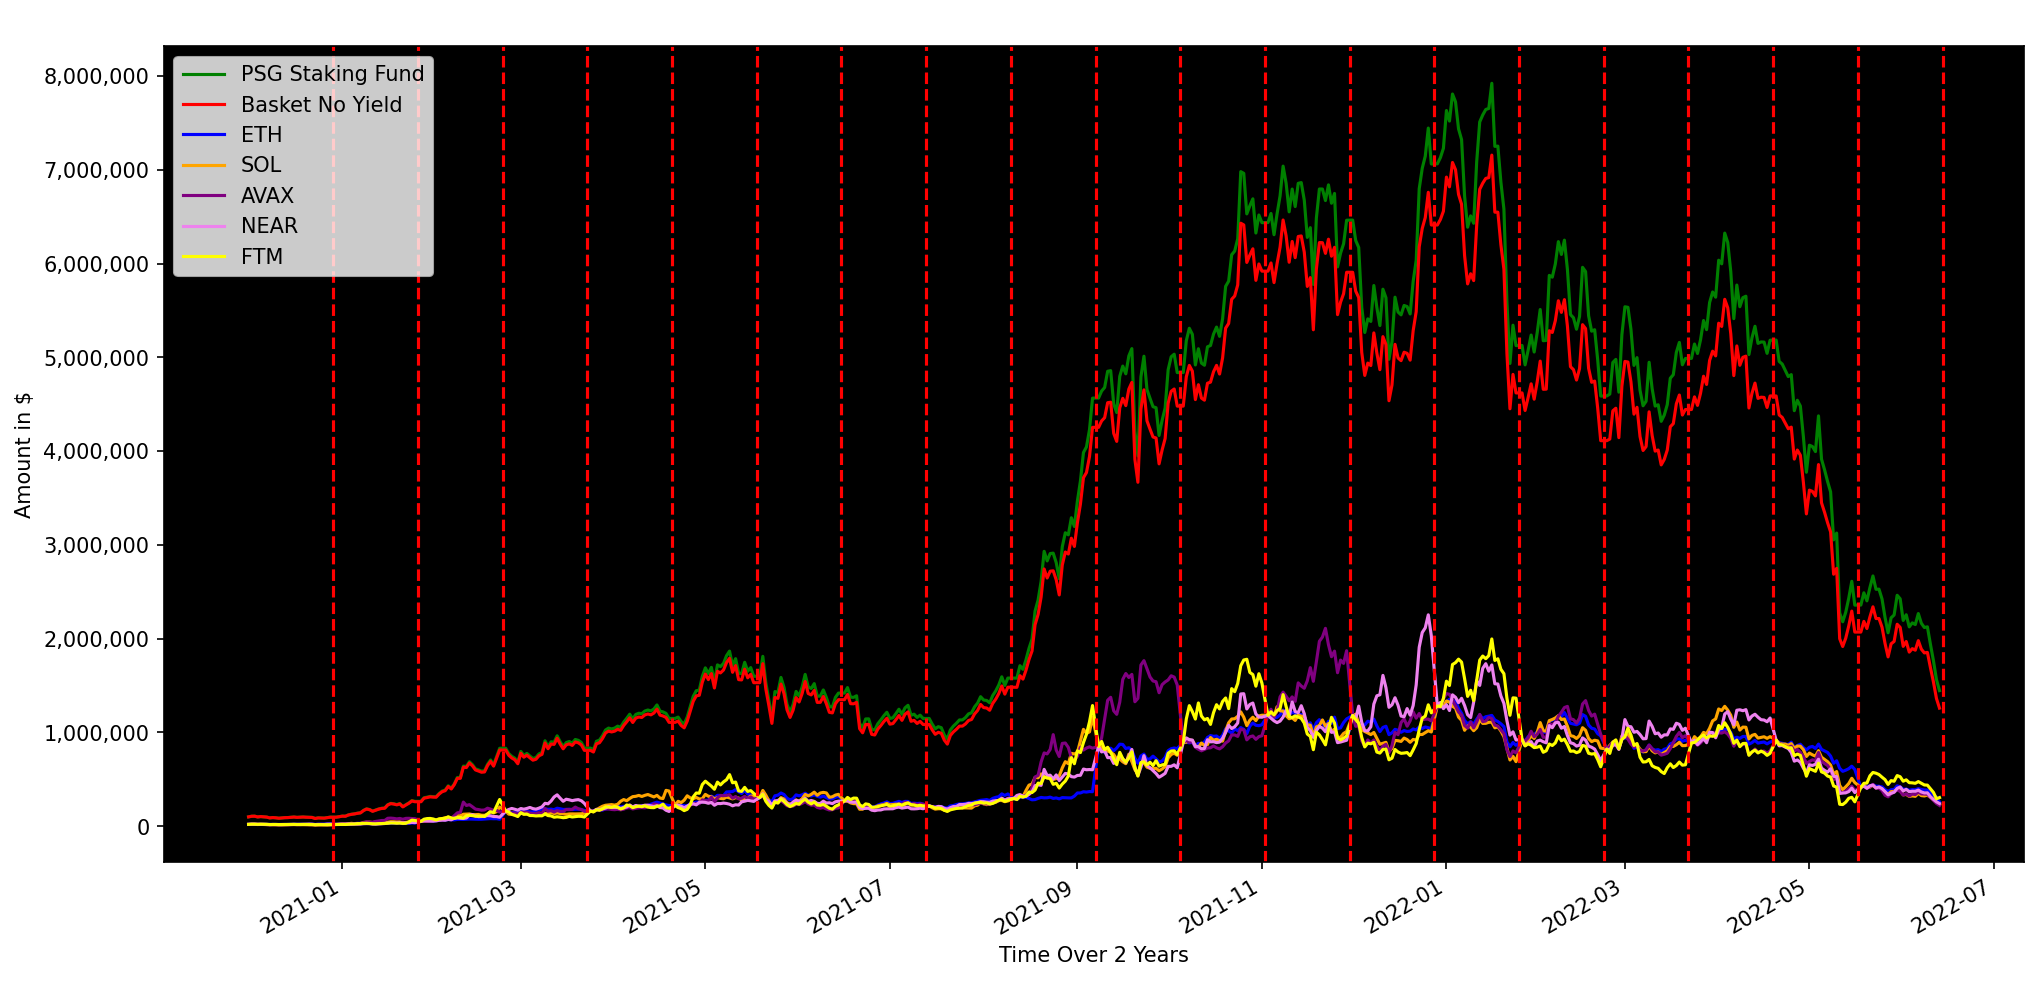

In [24]:
# Second Scenario - Real Observed Yields with full even spread

# ETH SOL AVAX NEAR FTM
monthly_data_set_2 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations":  [0.2,0.2,0.2,0.2,0.2],
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":[0.2,0.2,0.2,0.2,0.2],
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":[0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":[0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations": [0.2,0.2,0.2,0.2,0.2],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_2,psg_staking_portfolio_df),monthly_data_set_2)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


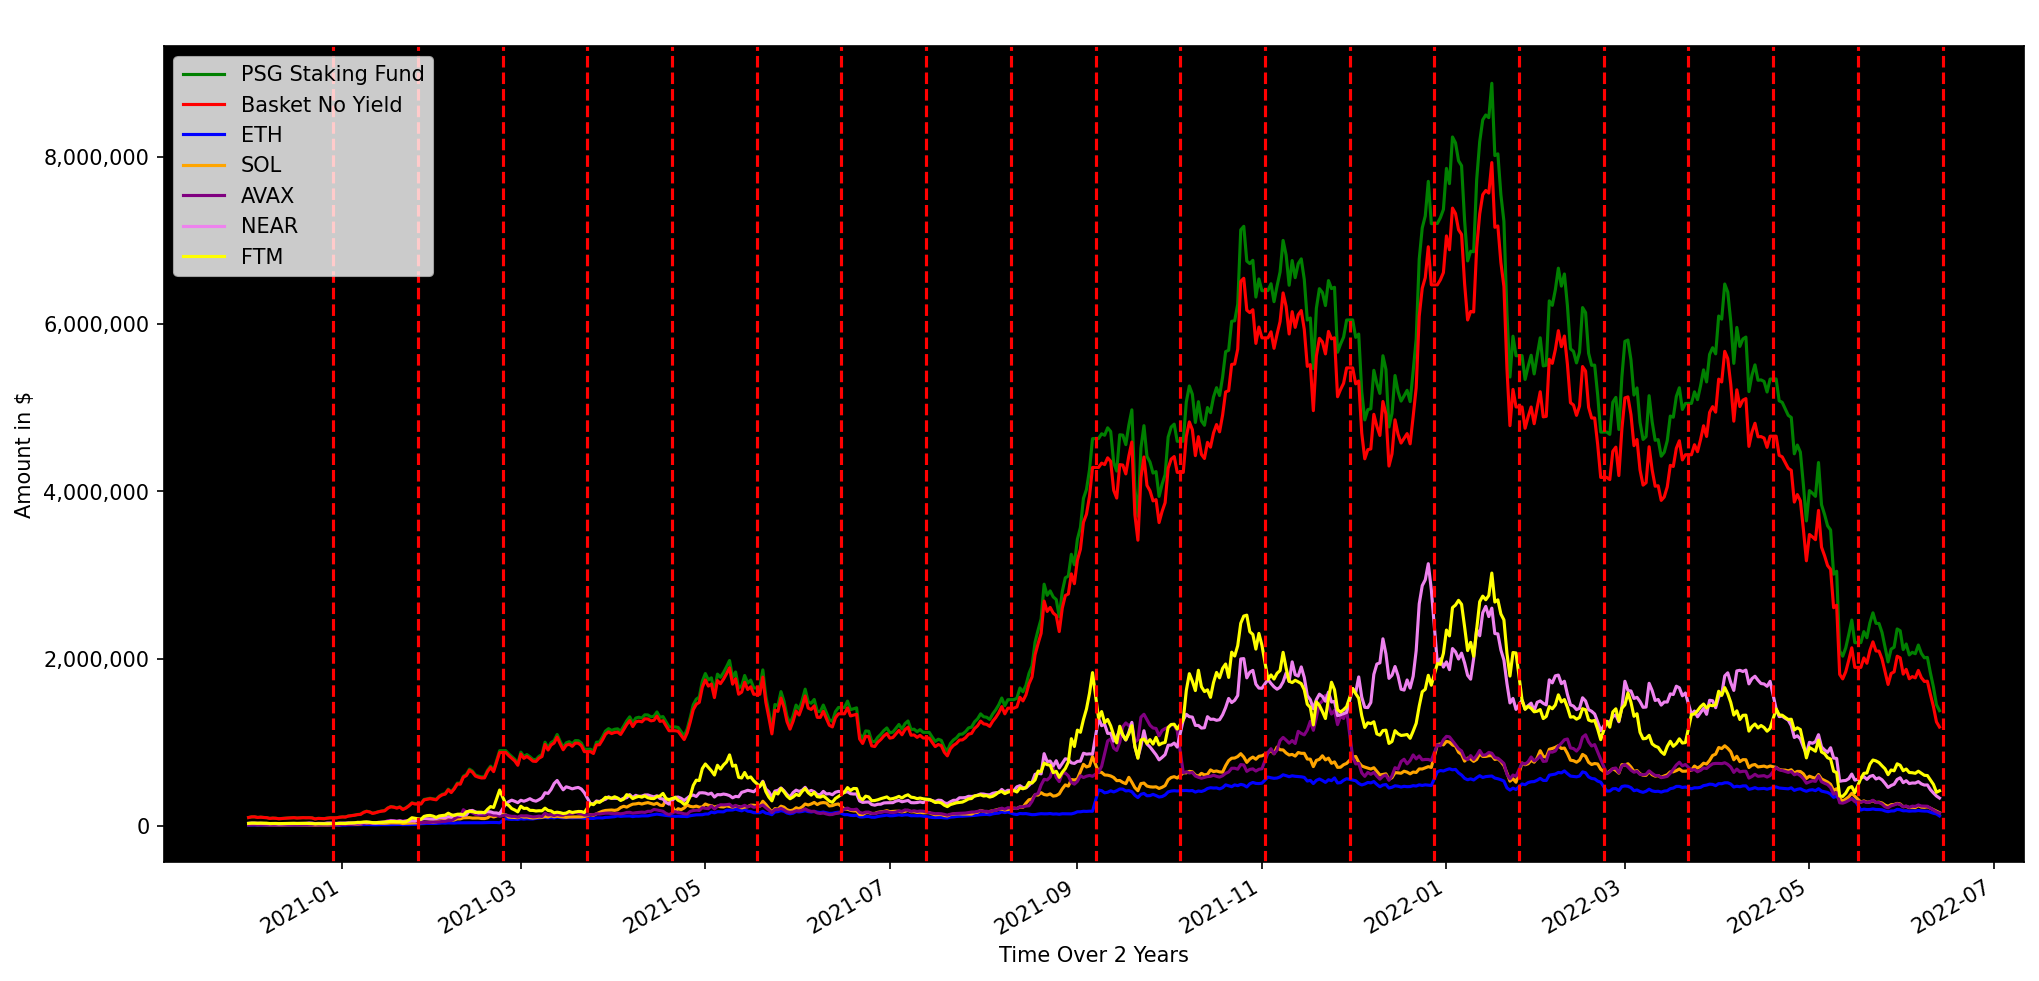

In [26]:
# Third Scenario with heavy weighted toward riskier higher yields


# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_3 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations":  [0.10,0.15,0.15,0.3,0.3],
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":[0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":[0.10,0.15,0.15,0.3,0.3],
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":[0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":[0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations": [0.10,0.15,0.15,0.3,0.3],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]


plot(model(monthly_data_set_scenario_3,psg_staking_portfolio_df),monthly_data_set_scenario_3)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


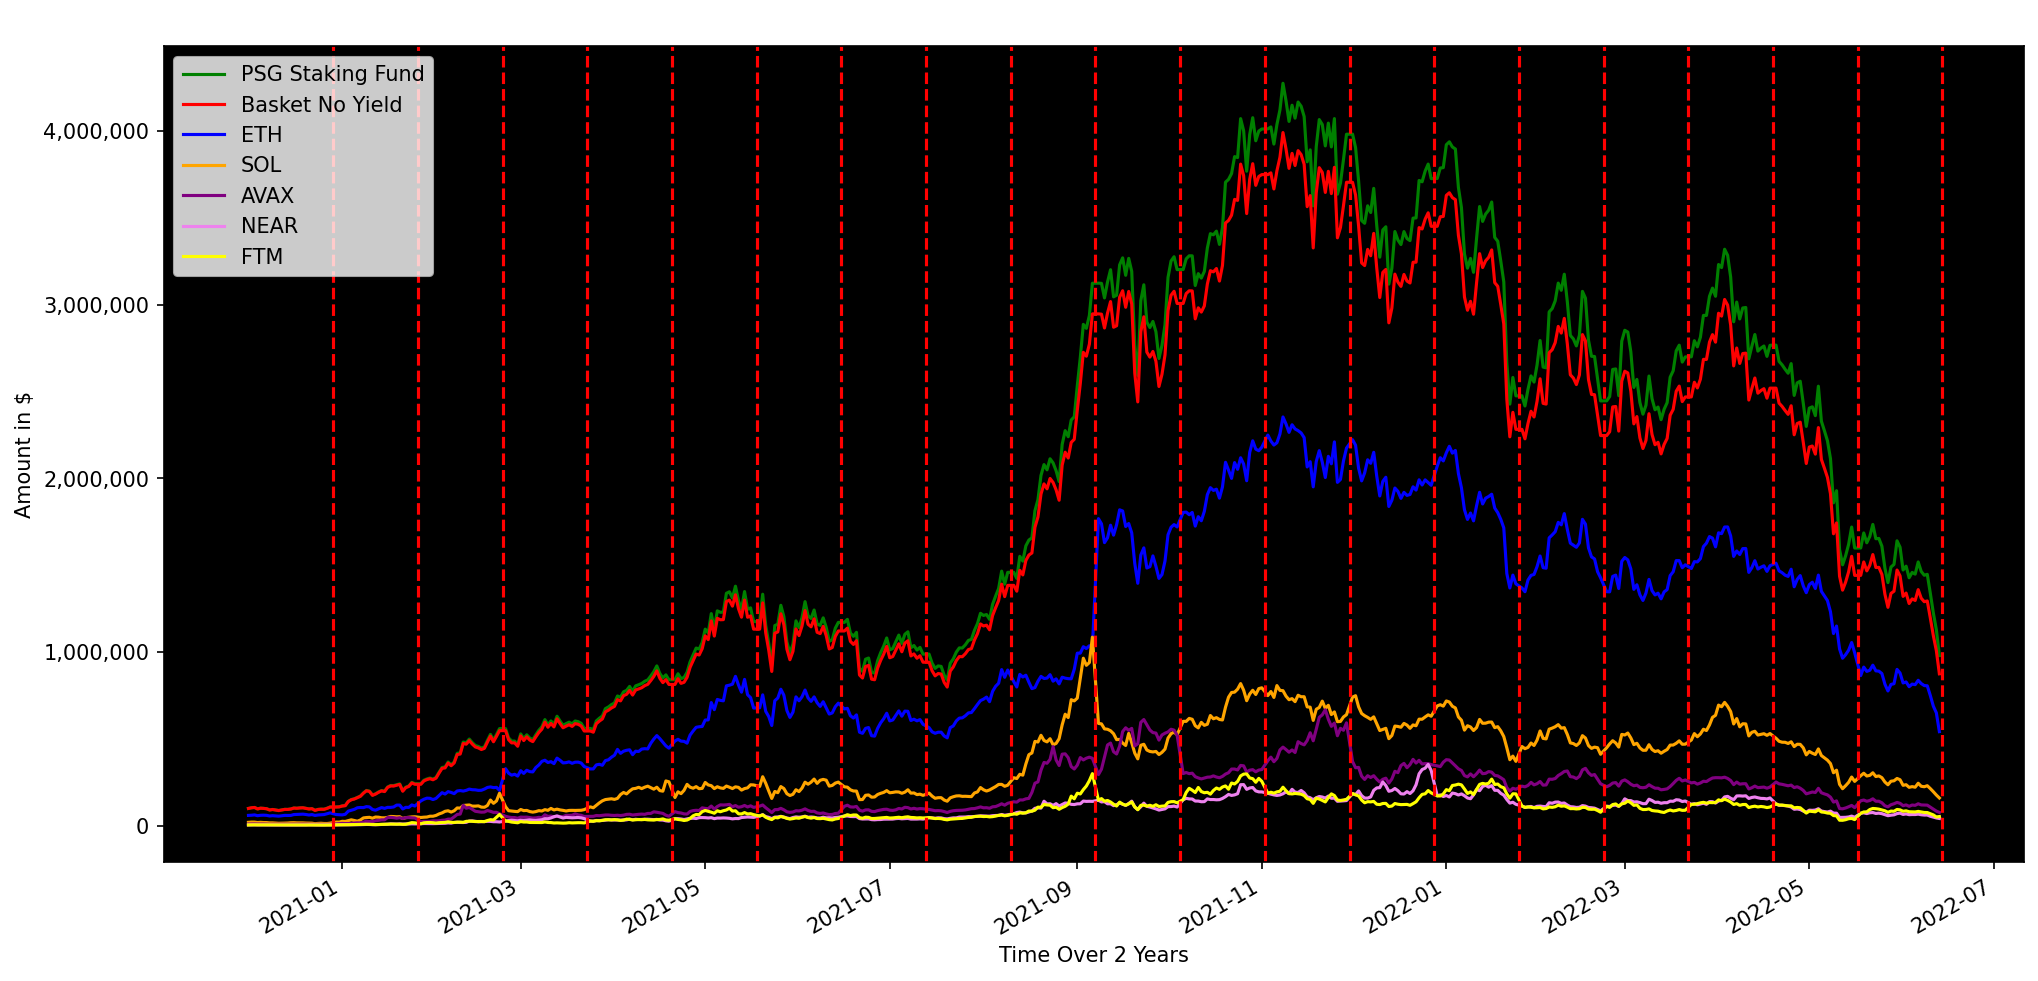

In [27]:
 # Fourth Scenario - Real Yields with Weighted by market cap


# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_4 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        # 2022
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": [0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations":[0.60,0.2,0.10,0.05,0.05],
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_scenario_4,psg_staking_portfolio_df),monthly_data_set_scenario_4)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


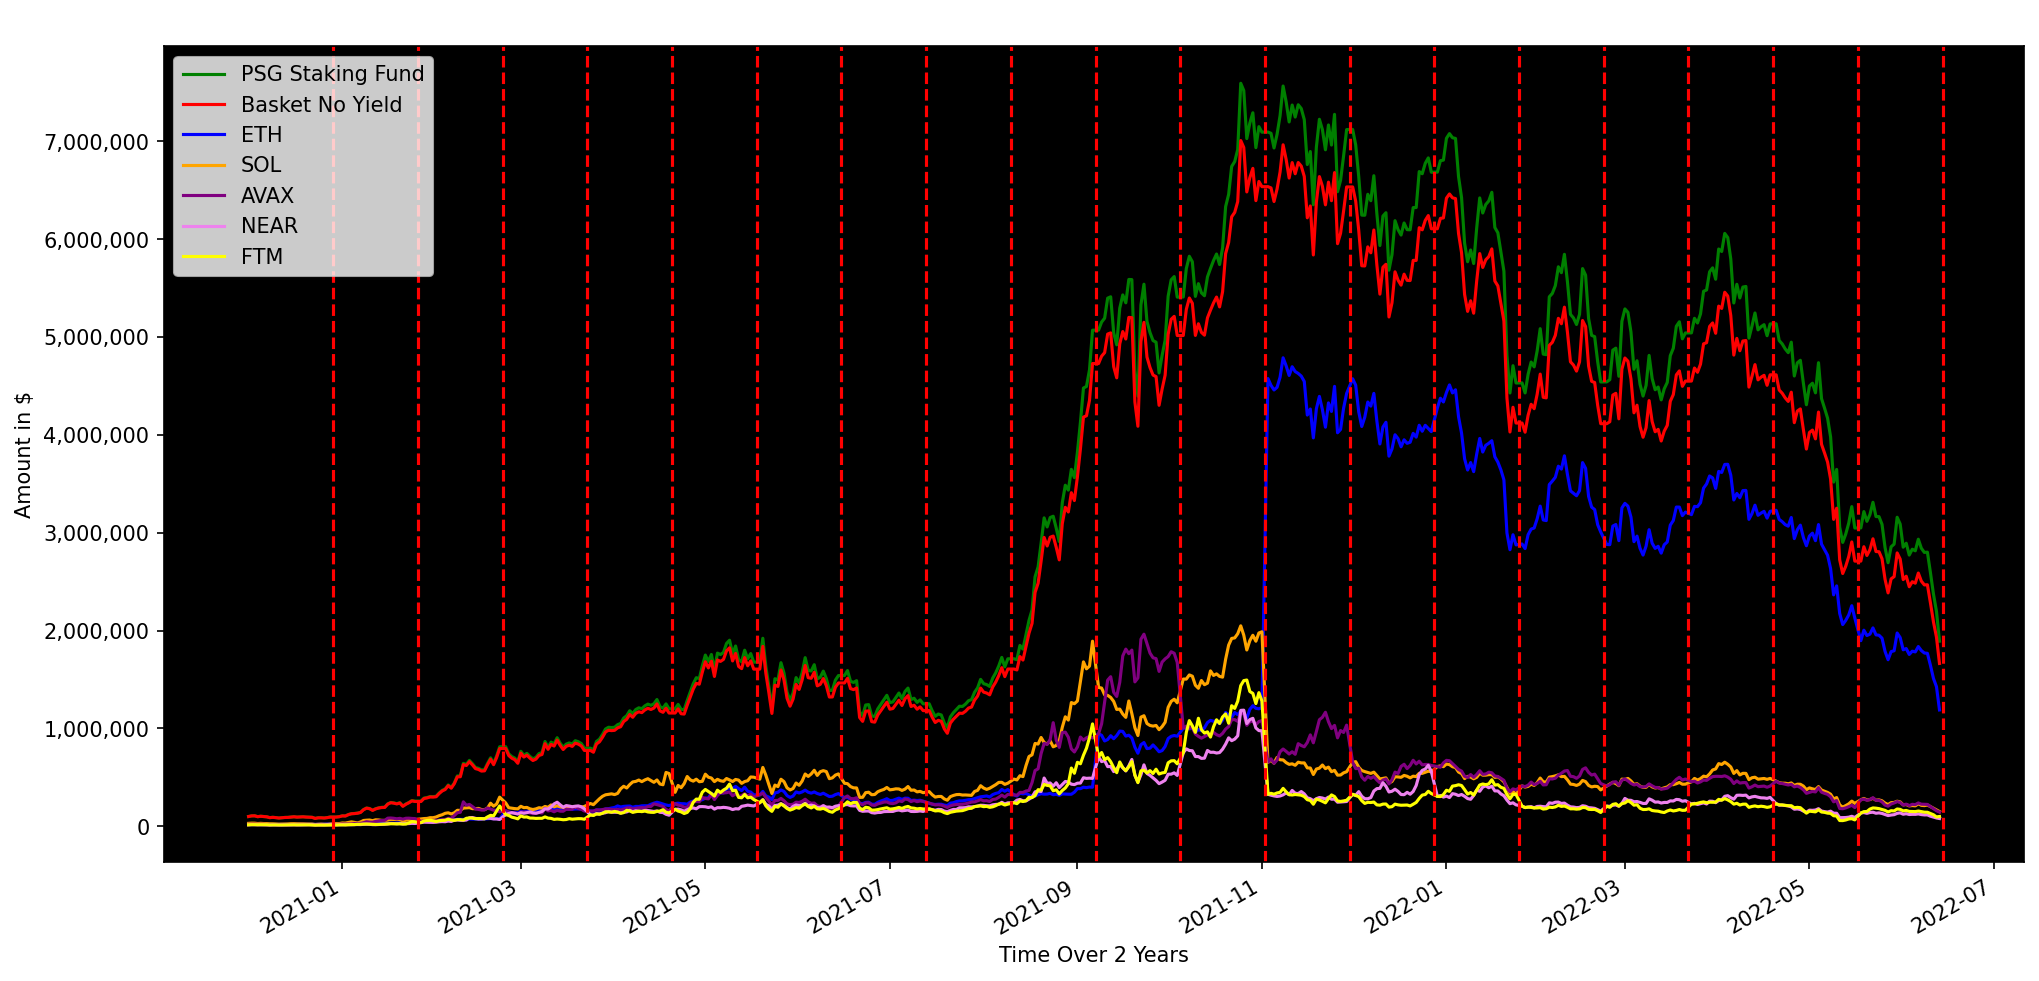

In [28]:
 # Fifth Scenario - 2021 - Original Alt Heavy, 2022 - Eth Heavy

alloc_2021 = [0.20,0.30,0.20,0.15,0.15]
alloc_2022 = [0.70,0.1,0.1,0.05,0.05]
    

# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_5 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": alloc_2021,
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": alloc_2021,
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": alloc_2021,
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": alloc_2021,
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":alloc_2021,
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        # 2022
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":alloc_2022,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations":alloc_2022,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_scenario_5,psg_staking_portfolio_df),monthly_data_set_scenario_5)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


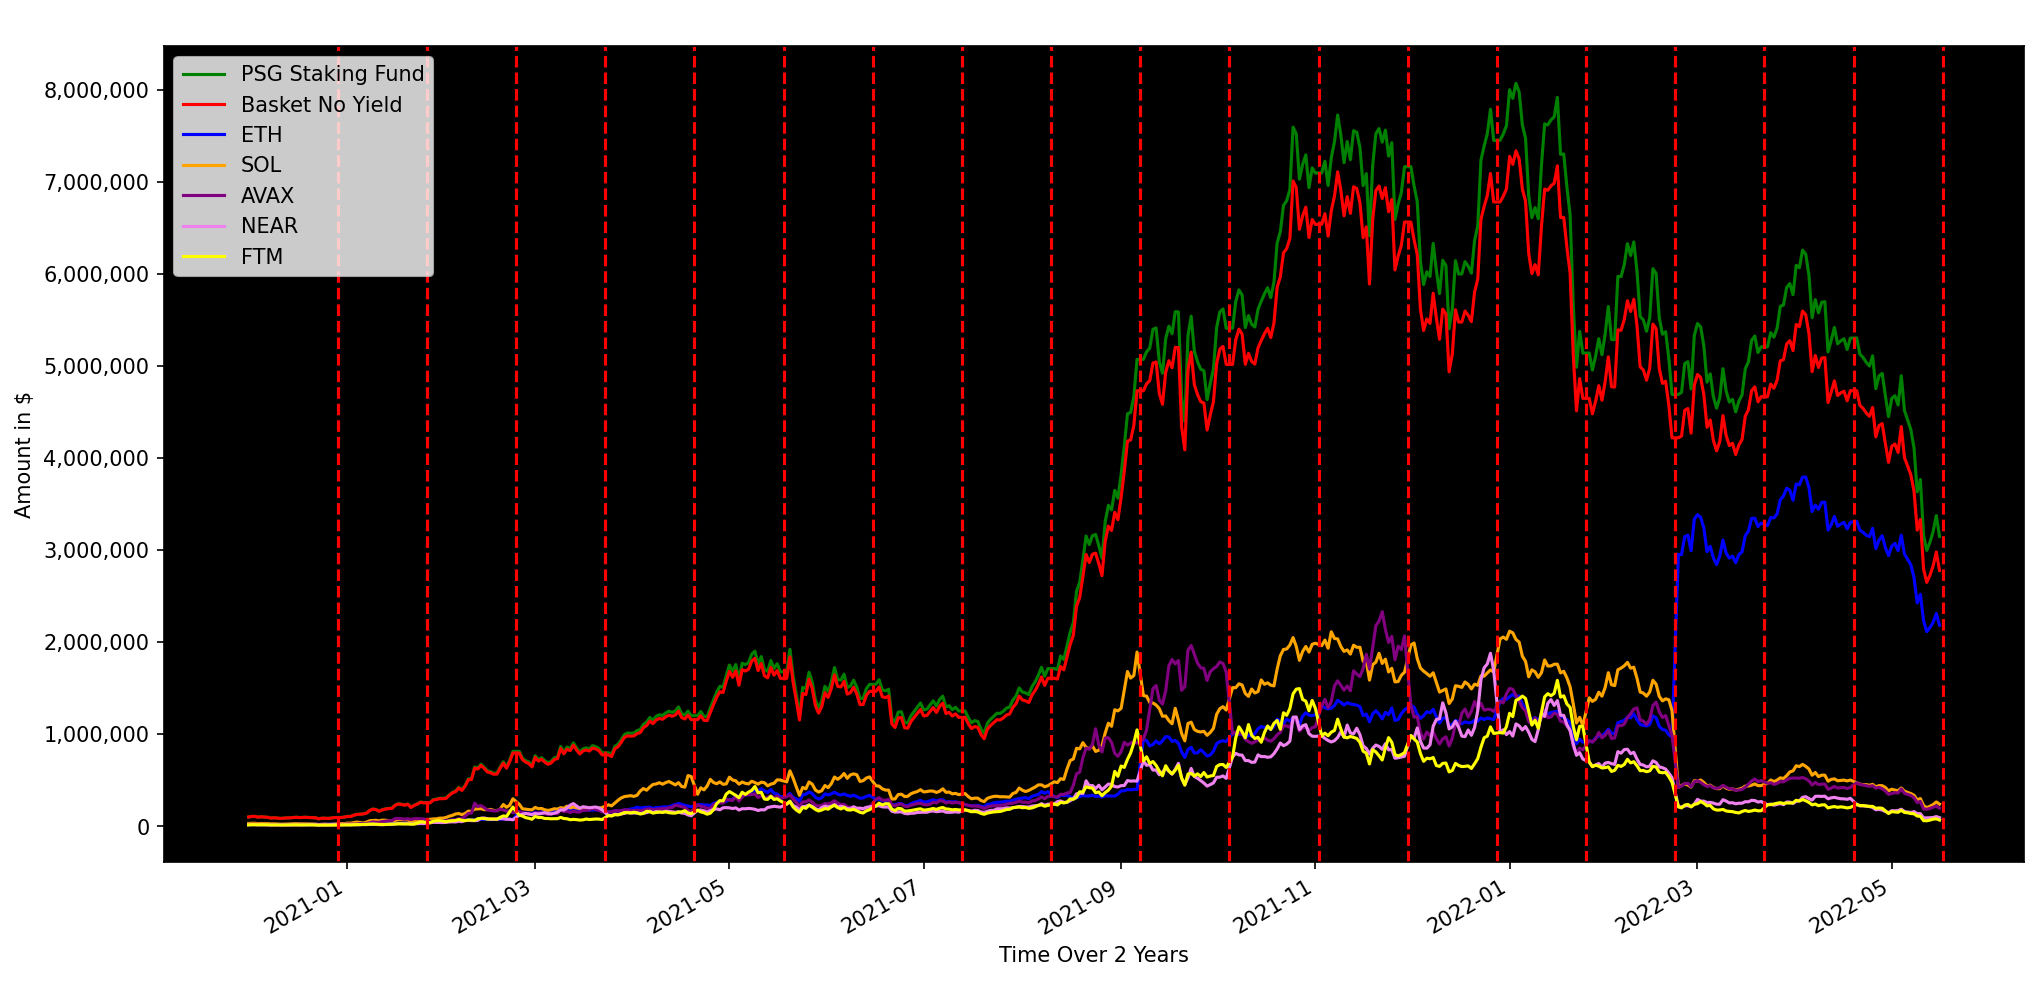

In [29]:
 # Six Scenario - 2021 - Original Alt Heavy, 2022 - Eth Heavy
# late rebalnce into 2022
alloc_2021 = [0.20,0.30,0.20,0.15,0.15]
alloc_2022 = [0.70,0.1,0.1,0.05,0.05]
    

# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_6 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": alloc_2021,
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": alloc_2021,
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": alloc_2021,
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": alloc_2021,
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":alloc_2021,
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        # 2022
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": alloc_2021,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":alloc_2022,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_scenario_6,psg_staking_portfolio_df),monthly_data_set_scenario_6)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


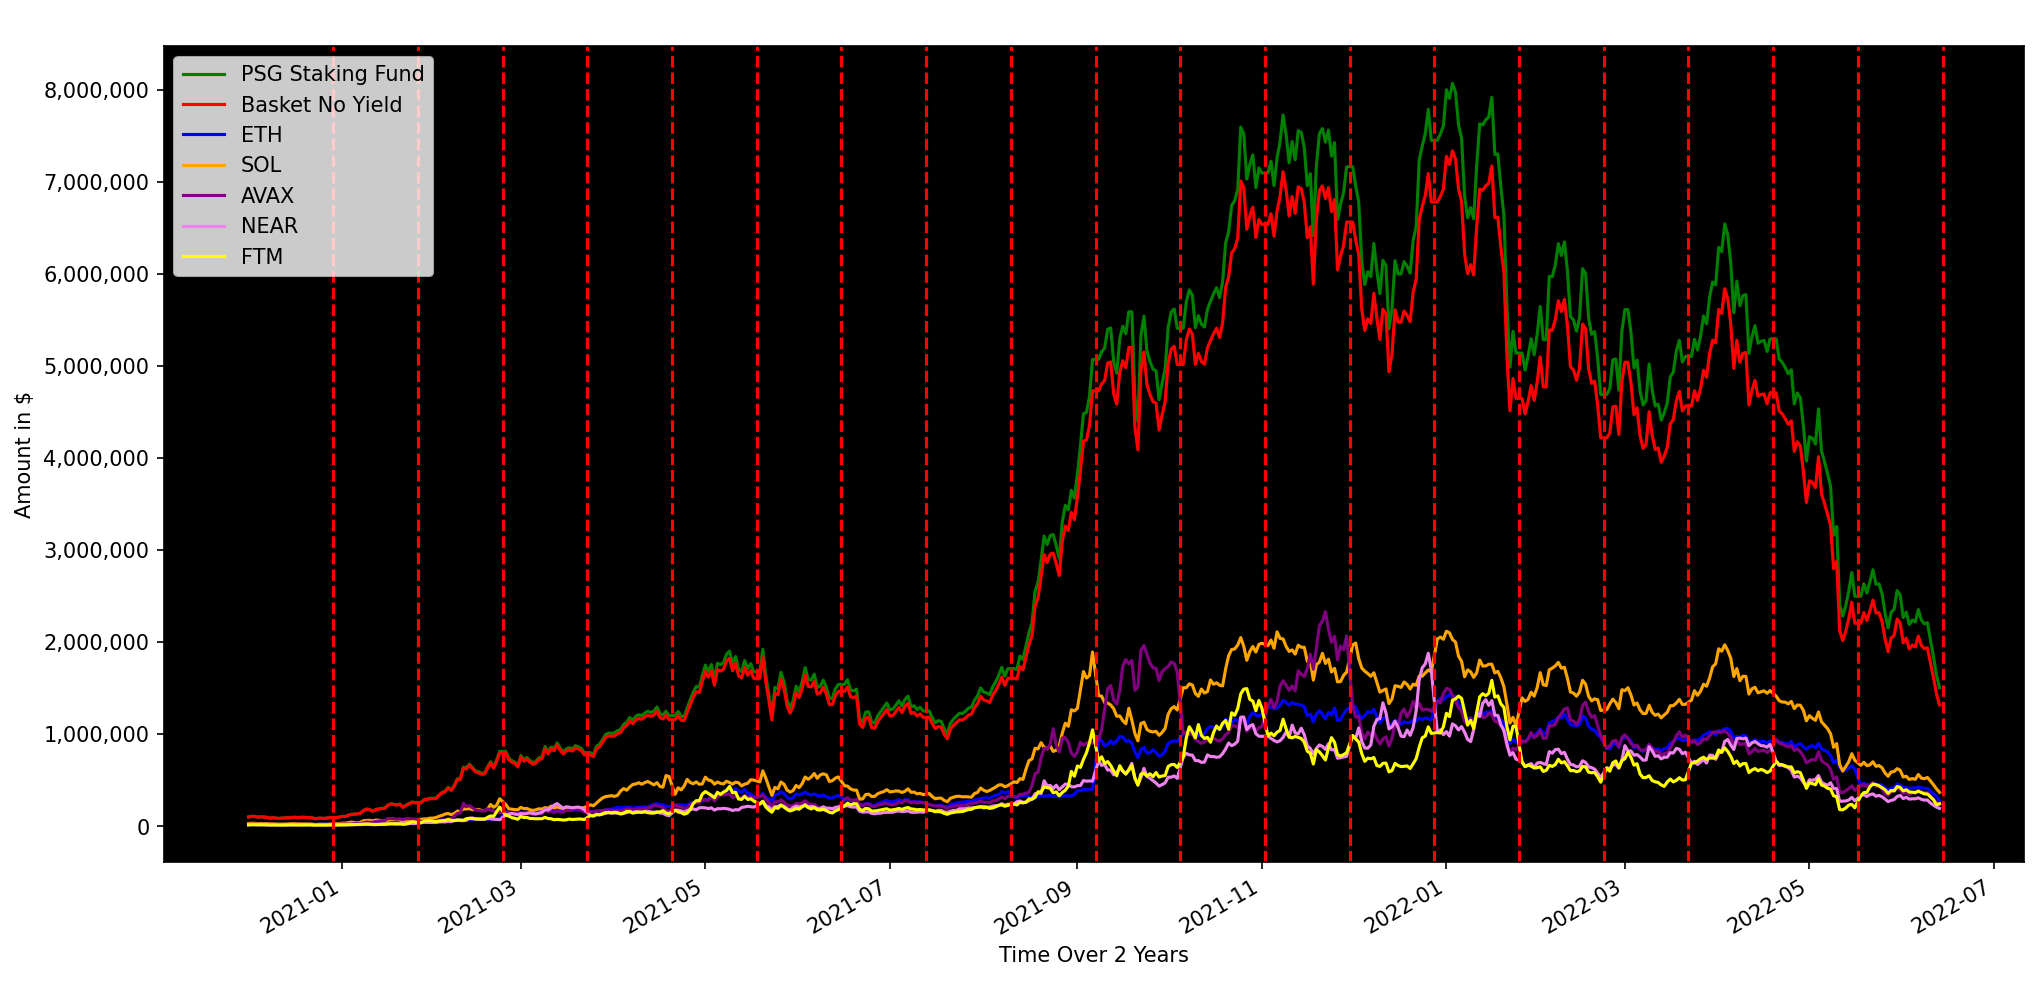

In [30]:
 # Six Scenario - 2021 - Original Alt Heavy, 2022 - Eth Heavy
# bno rebalance into 2022
alloc_2021 = [0.20,0.30,0.20,0.15,0.15]
alloc_2022 = [0.70,0.1,0.1,0.05,0.05]
    

# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_7 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": alloc_2021,
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": alloc_2021,
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": alloc_2021,
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations": alloc_2021,
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": alloc_2021,
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":alloc_2021,
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":alloc_2021,
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":alloc_2021,
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        # 2022
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":alloc_2021,
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": alloc_2021,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":alloc_2021,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations":alloc_2021,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":alloc_2021,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations":alloc_2021,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_scenario_7,psg_staking_portfolio_df),monthly_data_set_scenario_7)

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


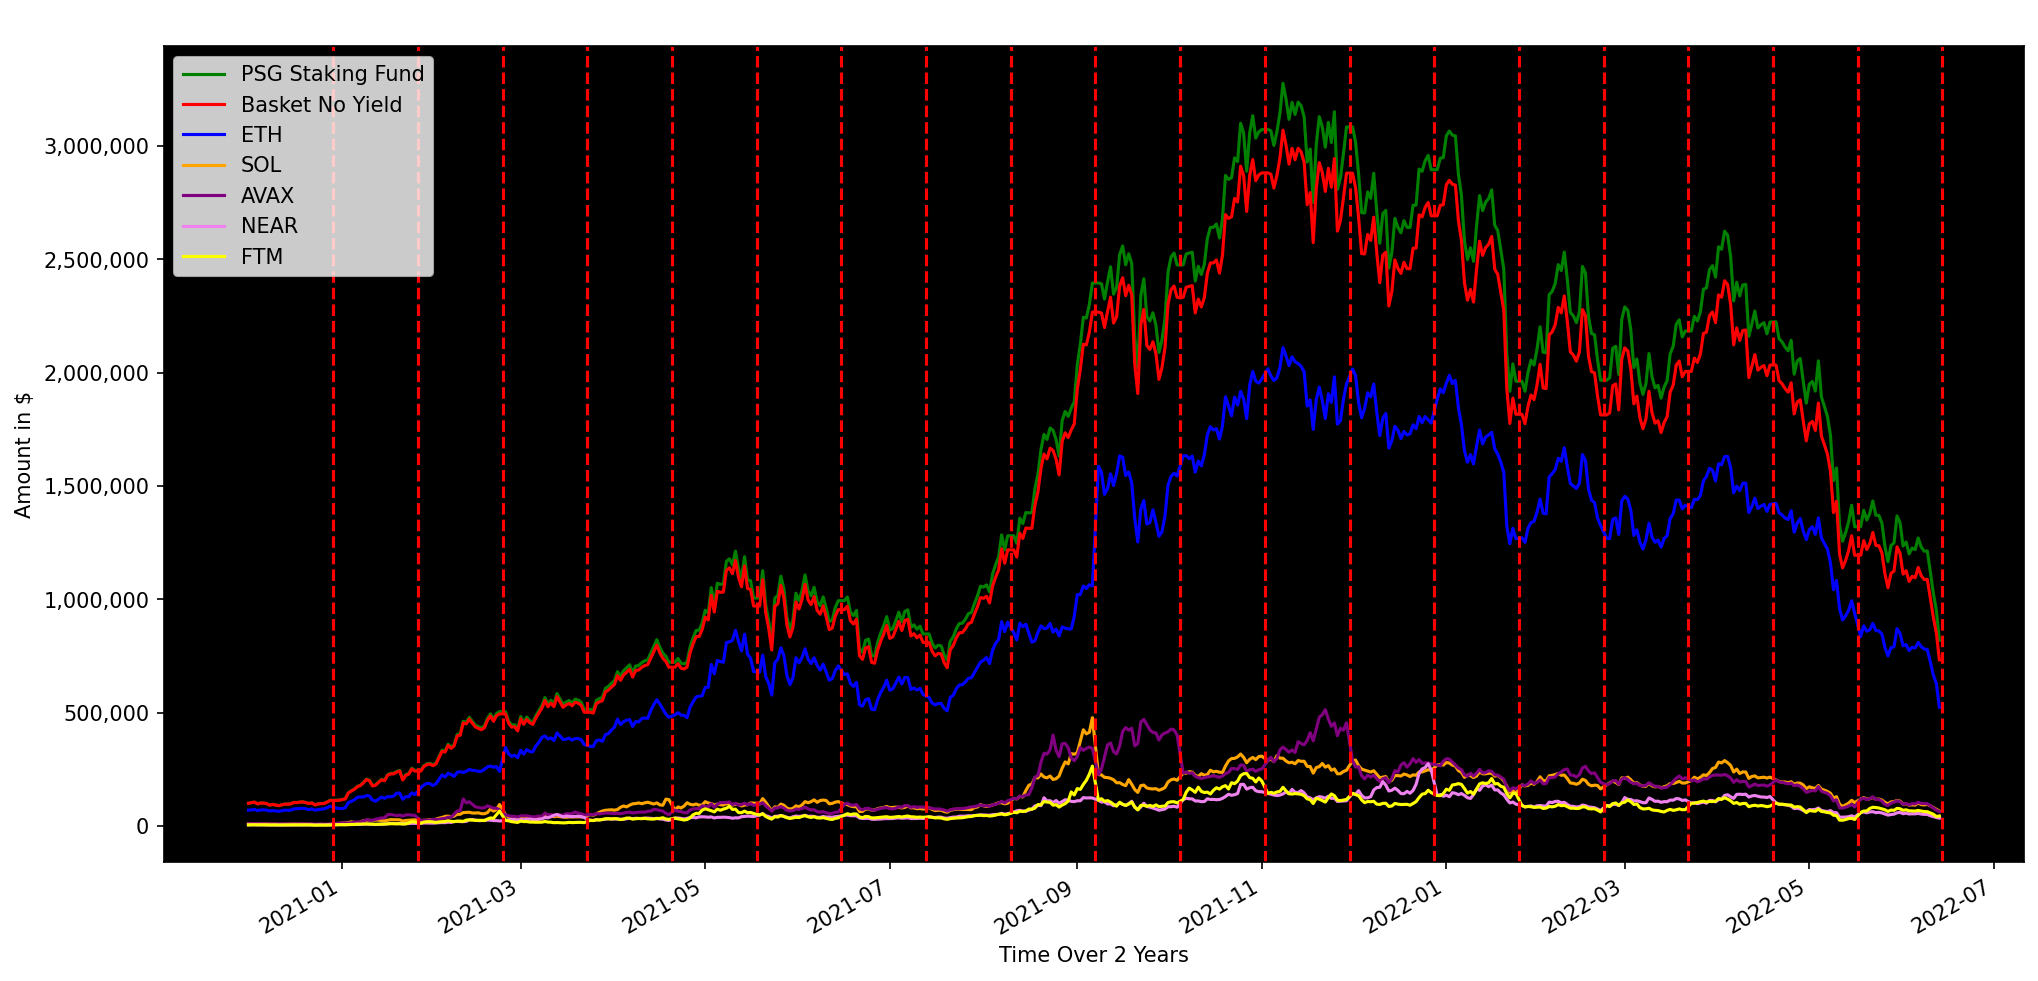

In [31]:
 # Six Scenario - 2021 - Original Alt Heavy, 2022 - Eth Heavy
# bno rebalance into 2022
alloc_2021 = [0.20,0.30,0.20,0.15,0.15]
alloc_2022 = [0.70,0.1,0.1,0.05,0.05]

# ETH SOL AVAX NEAR FTM
monthly_data_set_scenario_8 = [
    {
        "start":start_time,
        "end":start_time + timedelta(weeks = 4*1),
        "allocations": alloc_2022,
        "yields":[8.8,12.9,7.0,9.0,15.3]
        
    },
     {
        "start":start_time + timedelta(weeks = 4*1,days=1),
        "end":start_time + timedelta(weeks = 4*2),
        "allocations": alloc_2022,
        "yields":[8.2,12.9,7.0,9.0,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*2,days=1),
        "end":start_time + timedelta(weeks = 4*3),
        "allocations": alloc_2022,
        "yields":[7.3,11.5,7.0,9.0,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*3,days=1),
        "end":start_time + timedelta(weeks = 4*4),
        "allocations": alloc_2022,
        "yields":[6.8,11.5,7.0,9.0,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*4,days=1),
        "end":start_time + timedelta(weeks = 4*5),
        "allocations": alloc_2022,
        "yields":[6.8,11.5,7.0,10.3,15.3]       
    },
     {
        "start":start_time + timedelta(weeks = 4*5,days=1),
        "end":start_time + timedelta(weeks = 4*6),
        "allocations": alloc_2022,
        "yields":[5.4,11.5,7.0,10.3,15.3]
    },
     {
        "start":start_time + timedelta(weeks = 4*6,days=1),
        "end":start_time + timedelta(weeks = 4*7),
        "allocations":alloc_2022,
        "yields":[5.2,11.5,7.0,10.3,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*7,days=1),
        "end":start_time + timedelta(weeks = 4*8),
        "allocations":alloc_2022,
        "yields":[5.2,11.5,7.0,10.3,15.3] 
    },
    {
        "start":start_time + timedelta(weeks = 4*8,days=1),
        "end":start_time + timedelta(weeks = 4*9),
        "allocations":alloc_2022,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*9,days=1),
        "end":start_time + timedelta(weeks = 4*10),
        "allocations": alloc_2022,
        "yields":[5.2,7.4,7.0,11.0,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*10,days=1),
        "end":start_time + timedelta(weeks = 4*11),
        "allocations":alloc_2022,
        "yields":[5.2,7.4,7.0,11.0,15.3]   
    },
    {
        "start":start_time + timedelta(weeks = 4*11,days=1),
        "end":start_time + timedelta(weeks = 4*12),
        "allocations":alloc_2022,
        "yields":[5.2,7.2,7.0,12.1,15.3]        
    },
    {
        # 2022
        "start":start_time + timedelta(weeks = 4*12,days=1),
        "end":start_time + timedelta(weeks = 4*13),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*13,days=1),
        "end":start_time + timedelta(weeks = 4*14),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]
    },
    {
        "start":start_time + timedelta(weeks = 4*14,days=1),
        "end":start_time + timedelta(weeks = 4*15),
        "allocations":alloc_2022,
        "yields":[4.4,7.2,7.0,12.1,15.3]  
    },
     {
        "start":start_time + timedelta(weeks = 4*15,days=1),
        "end":start_time + timedelta(weeks = 4*16),
        "allocations": alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*16,days=1),
        "end":start_time + timedelta(weeks = 4*17),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
    {
        "start":start_time + timedelta(weeks = 4*17,days=1),
        "end":start_time + timedelta(weeks = 4*18),
        "allocations":alloc_2022,
        "yields":[4.4,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*18,days=1),
        "end":start_time + timedelta(weeks = 4*19),
        "allocations":alloc_2022,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    },
     {
        "start":start_time + timedelta(weeks = 4*19,days=1),
        "end":start_time + timedelta(weeks = 4*20),
        "allocations":alloc_2022,
        "yields":[18.0,5.6,7.0,12.1,15.3]        
    }
]

plot(model(monthly_data_set_scenario_8,psg_staking_portfolio_df),monthly_data_set_scenario_8)